# Exploring Lift via Candidate Pulsar Profile Classification

When searching for pulsars in radio waves, you not only have many candidate sources to consider (many things in the universe emit at radio wavelengths) but you also have a potentially large phase space to search over, both in rotational frequency and dispersion measure (DM).  For one pointing, processing the data can result in many candidates and some of those will be due to radio frequency interference (RFI) or otherwise spurious.

These candidate profiles need to be investigated and evaluated.  Within a few weeks, a human can learn to distnguish good candidates from noise (and most observatories/researchers do have ways to mask known/common sources of RFI), but looking through the profiles by hand still takes time and, inevitably, some processing power and time, and sometimes observation time, will be spent investigating noise signals. Can machine learning do better?

This notebook uses the question as framed above to demonstrate the power of lift in classification problems which are either difficult and/or have a significant class imbalance where the rare class is of interest.  We don't push terribly hard to improve our classification algorithm, rather, we choose to demonstrate how we can take a classifier of even middling performance and more efficiently use limited resources by ranking records instead of focusing on specific class predictions.

In [1]:
import pandas as pd
from pathlib import Path

The dataset was obtained from [this Kaggle page](https://www.kaggle.com/datasets/charitarth/pulsar-dataset-htru2/data), though if you do a search you'll find several other copies of the same dataset.  The page we used did actually have more information and attribution.  For further details on this datset, you can check out [this page](https://archive.ics.uci.edu/dataset/372/htru2).

For those who were wondering HTRU = High Time Resolution Universe (see, for instance [Keith et al., 2010, MNRAS, 409, 619](https://academic.oup.com/mnras/article/409/2/619/1037409)), a survey initially started with Parkes in Australia and with a Northern counterpart later added using Effelsberg in Germany.

However, we managed to track things down even further to [Lyon et al., 2016, MNRAS, 459, 1104](https://academic.oup.com/mnras/article/459/1/1104/2608953).  This paper introduces the 8 parameters used and explains the provenance of the dataset, explaining why it is "HTRU2" and what the "HTRU1" datset is, and gives yet another (maybe the original) link to the data [here](https://figshare.com/articles/dataset/HTRU2/3080389/1).

From the Lyon et al. paper, we know that these are individually candidates, which were labeled by hand.  Ostensibly, they are at different positions on the sky, keeping only the best for each position, but that wasn't immediately clear from ther paper.  This is both good and bad for our performance, as it means the really bad, easily identifiable radio frequency interference (RFI) or other noise candidates were already tossed and are not available for us to train on.

We will proceed under the assumption, then, that we are identifying candidates for reobservation with longer, dedicated pointings (though you can imagine that we might also be flagging promising candidates for more computationally intense acceleration searches or similar).  Observing time is precious and proposal calls are highly competitive.  We will proceed under the constraint that we will only be allotted resources to reobserve 10% of our eventual candidate list, which will correspond to the test partition we create later.

Our goal, then, is to train a classifier and come up with a scheme to to select the best 10% to reobserve.  We want to select sources in a way which optimizes our observing efficiency (e.g., the fraction, or percentage, of actual pulsars among the sources we reobserve).

Note, even though we have labels and will evaluate the model on the test set, the premise for this scenario is that we would select 10% of the sources and we only know our observing efficiency after the observations have been made and the data processed, which takes a lot longer than calling the predict method on a trained classifier and comparing to known labels.

In [2]:
data_dir = Path.cwd().parent/'data'

The CSV file from Kaggle does not have column names, so we need to add those, and then we'll save a named version of the file for ease in future use.

In [3]:
psr_df = pd.read_csv(data_dir/'HTRU_2.csv',
                     names = ['profile_mean', 'profile_std', 'profile_kurt', 'profile_skew',
                              'dmsnr_mean', 'dmsnr_std', 'dmsnr_kurt', 'dmsnr_skew', 'psr'])

psr_df.head()

profile_mean  profile_std  profile_kurt  profile_skew  dmsnr_mean  \
0    140.562500    55.683782     -0.234571     -0.699648    3.199833   
1    102.507812    58.882430      0.465318     -0.515088    1.677258   
2    103.015625    39.341649      0.323328      1.051164    3.121237   
3    136.750000    57.178449     -0.068415     -0.636238    3.642977   
4     88.726562    40.672225      0.600866      1.123492    1.178930   

   dmsnr_std  dmsnr_kurt  dmsnr_skew  psr  
0  19.110426    7.975532   74.242225    0  
1  14.860146   10.576487  127.393580    0  
2  21.744669    7.735822   63.171909    0  
3  20.959280    6.896499   53.593661    0  
4  11.468720   14.269573  252.567306    0

In [4]:
psr_df.to_csv(data_dir/'HTRU_2_withColumnNames.csv', index = False)

In [5]:
print(f'We have {sum(psr_df.psr)/len(psr_df):.2%} psr = 1 sources in the dataset.')

We have 9.16% psr = 1 sources in the dataset.


As we can see above, this is a highly unbalanced dataset.  Not too surprising, there are a lot of radio sources in the sky and if they were all pulsars this dataset would likely be a lot less interesting.

This explains why astronomers can't simply observe all of these sources.  Observatories only have so much time available and there are a lot of people wanting to use them, and for some reason they don't all want to just focus on pulsars.

For this demonstration, we're going to split the dataset into training and test partitions. We will then pretend that our test partition represents the best candidate profiles from many different sources, which we would like to follow up.  The problem, however, is that we only have enough resources (observing time, money to fund researchers, computational allotment, etc.) to observe 10% of the candidates (remember, for us that means 10% of our test partition).

Our task, therefore, is to develop an algorithm/model to select the optimal 10% of the test partition to observe.

Let's try a simple decision tree classifier.  We'll grow the tree fully and then prune it back via cross validation and the cost complexity parameter, alpha.  The decision tree is a nice, quick choice because it doesn't require any scaling of numerical parameters or consideration of parameter correlation.

Let's take care of some imports.

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

import dmba

We'll do a fairly 'typical' (sometimes I think people, including me, use that word too freely) 80% train - 20% test split.  We'll specify the random\_state for the sake of reproducibility.  Given the class imbalance, we'll stratify on the 'psr' column to try and keep similar percentages.  With this split, we'll get 3,580 candidates in our test set, meaning our hypothetical budget allows us to reobserve 358 sources.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(psr_df.drop(columns = ['psr']), psr_df.psr,
                                                    test_size = 0.2, random_state = 7,
                                                    shuffle = True, stratify = psr_df.psr)

print(f'We have {sum(y_train)/len(y_train):.2%} psr = 1 sources in the training set.')
print(f'We have {sum(y_test)/len(y_test):.2%} psr = 1 sources in the test set.')

We have 9.16% psr = 1 sources in the training set.
We have 9.16% psr = 1 sources in the test set.


Well, that worked out a bit more precisely than expected, but it should be helpful.  Granted, we could have explored other options to deal with the class imbalance, but this is what we're going with.

Now we can simply create our decision tree and train it.  Because we do have imbalanced classes, we will set ```criterion = 'entropy'``` because that splitting criterion is said to do better than _gini_ when it comes to imbalanced classes.

In [8]:
full_dt_clf = DecisionTreeClassifier(criterion = 'entropy')

#now let's train, letting the tree grow fully
full_dt_clf.fit(X_train, y_train)

#and we'll show how it has grown fully by obtaining 100% accuracy
y_pred_train_full = full_dt_clf.predict(X_train)

dmba.classificationSummary(y_train, y_pred_train_full, ['Not Pulsar', 'Pulsar'])

Confusion Matrix (Accuracy 1.0000)

           Prediction
    Actual Not Pulsar     Pulsar
Not Pulsar      13007          0
    Pulsar          0       1311


In [9]:
full_dt_clf.get_depth()

24

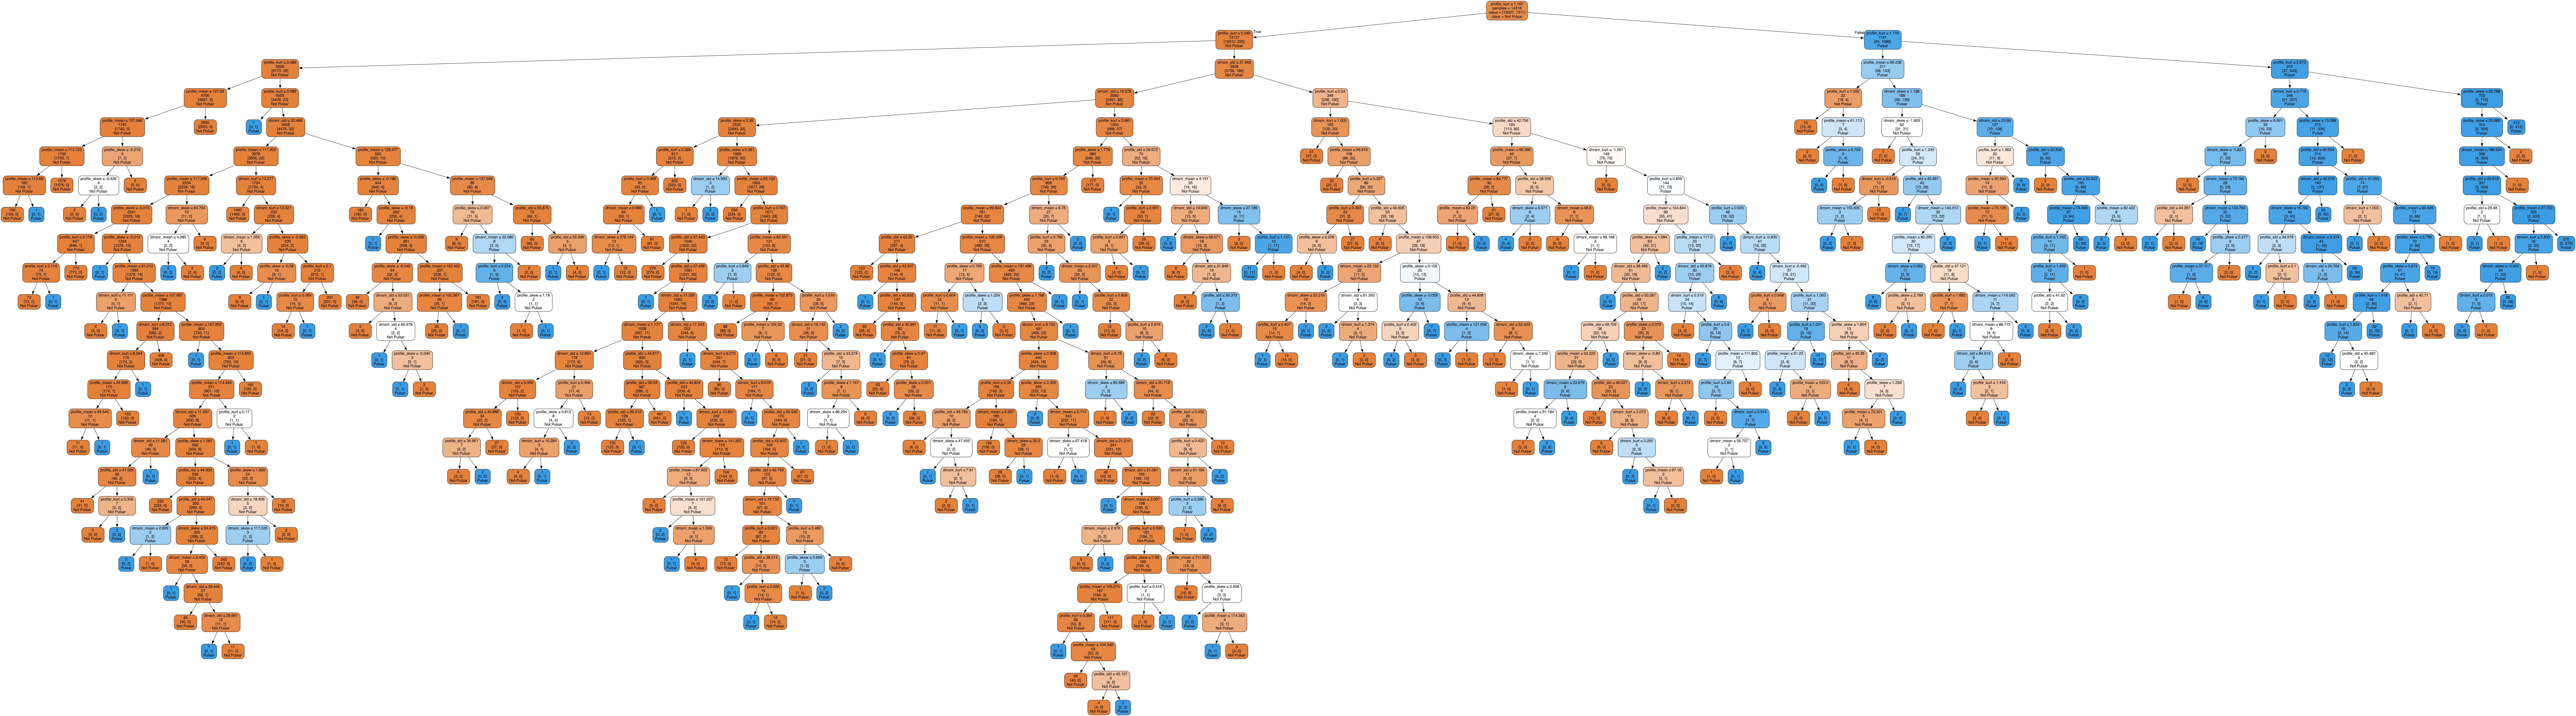

In [10]:
dmba.plotDecisionTree(full_dt_clf,
                      feature_names = X_train.columns,
                      class_names = ['Not Pulsar', 'Pulsar'])

This is a very deep tree and wide tree.  Note how in the plot above all of the terminal nodes are either deep orange (100% psr = 0 in that leaf) or deep blue (100% psr = 1 in that leaf).  This classifier does great on the training dataset but will generalize poorly.

In the cell below, we use this classifier on our test partition. If we consider overall accuracy, we do fairly well with a score 96.9%, but we have significant class imbalance in this problem.  When we break things down by class, we see we only get a score of 81.4% on the psr = 1 sources.

In [11]:
y_pred_test_full = full_dt_clf.predict(X_test)

print(classification_report(y_test, y_pred_test_full))

dmba.classificationSummary(y_test, y_pred_test_full, ['Not Pulsar', 'Pulsar'])

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3252
           1       0.87      0.83      0.85       328

    accuracy                           0.97      3580
   macro avg       0.92      0.91      0.92      3580
weighted avg       0.97      0.97      0.97      3580

Confusion Matrix (Accuracy 0.9729)

           Prediction
    Actual Not Pulsar     Pulsar
Not Pulsar       3210         42
    Pulsar         55        273


In [12]:
268/358

0.7486033519553073

If we simply took all those profiles classified as psr = 1 (317) and filled in the remaining 41 randomly from the remaining sources (which are only 1.9% pulsars), we can expect to select only 1 actual pulsar.  That seems rather wasteful, we might get lucky and pick up more than 1, but we might also get unlucky and only get 0 pulsars in our other 41 sources.  This gives an overall expected observing efficiency of 268/358 * 100% = 74.9%.  That's not terrible, but suggests 25% of our observations are wasted (for our purposes)

Is there a better way to choose sources?  This is where the lift score comes in.  To calculate lift, you rank your records by their probability of belonging to the source of interest and then split the data into percentiles (for our purposes, deciles).  In each percentile chunk, the lift score is the number of records actually belonging to the class of interest, regardless of their predicted class, divided by the number you would expect from randomly picking sources.  Ideally, you want a number greater than 1 in your lower percentiles.

In [13]:
import matplotlib.pyplot as plt
import mplcyberpunk

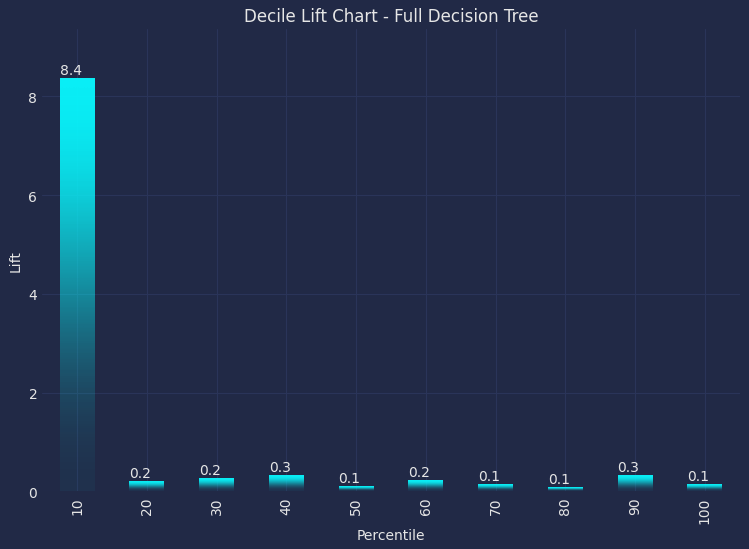

In [14]:
pred_full_df = pd.DataFrame({'actual': y_test.to_numpy(),
                             'prediction': full_dt_clf.predict_proba(X_test)[:,1]})\
                                .sort_values(by = 'prediction', ascending = False)

with plt.style.context('cyberpunk'):
    fig, ax = plt.subplots()
    fig.set_size_inches(h = 6, w = 9)
    
    ax = dmba.liftChart(pred_full_df.actual, ax = ax)
    ax.set_title('Decile Lift Chart - Full Decision Tree')

    mplcyberpunk.add_bar_gradient(ax.patches)

    fig.savefig('DecileLift_FullTree.png')

The maximum lift we can expect is the reciprocal of the prevalence of the class in the sample percentage, or 1/0.0916 = 10.92 for our example.  Clearly, we don't reach that pure decile of maximum lift, but we do fairly well.  However, we can't actually reach that maximum lift because it would mean we had all sources in the top 10% (358) as pulsars, but we only have 328 psr = 1 sources in the test set, which means our max possible lift is 328/ (0.0916 * 358) = 10.

If we were to rank our sources by predicted psr = 1 probability, we would get all of the sources classified as psr = 1 and we do manage to pick up one more (see output of the cell below), which is really no better than randomly selecting from the predicted psr = 0 sources, as we discussed earlier.

In [15]:
print(f'If we took the top decile, we would have {sum(pred_full_df.actual.iloc[:358])} pulsars in our sample.')

If we took the top decile, we would have 274 pulsars in our sample.


So maybe lift isn't that helpful afterall?  Wait, wait, wait...

Let's not get ahead of ourselves, we know the fully-grown tree is unlikely to generalize well, so let's prune it back using cross validation.  We will, at first, simply optimize for accuracy.

First, we need to get the pruning cost complexity path.

In [16]:
prune_alphas = full_dt_clf.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas']

print(f'This leaves us with a grid of {len(prune_alphas)} values to check.')
print(f'Doing a quick sanity check, the minimum value is {min(prune_alphas):.2e}.')

This leaves us with a grid of 156 values to check.
Doing a quick sanity check, the minimum value is 0.00e+00.


In [17]:
gscv_dt_accuracy = GridSearchCV(DecisionTreeClassifier(criterion = 'entropy'),
                       [{'ccp_alpha': prune_alphas}],
                       cv = 5,
                       n_jobs = 5,
                       scoring = 'accuracy',
                       return_train_score = True)

gscv_dt_accuracy.fit(X_train, y_train)

print('The best parameter is:',gscv_dt_accuracy.best_params_)
print(f'With best overall accuracy of {gscv_dt_accuracy.best_score_:.2%}')

The best parameter is: {'ccp_alpha': 0.002351857707410379}
With best overall accuracy of 97.74%


In [18]:
print(f'The 5-fold cross validated decision tree, optimized for accuracy, reaches a maximum depth \
of {gscv_dt_accuracy.best_estimator_.get_depth()}.')

The 5-fold cross validated decision tree, optimized for accuracy, reaches a maximum depth of 3.


That's a pretty shallow tree with decent performance (generalizing better than our fully grown tree), but still only 82.3% accuracy on the psr = 1 class.  Let's take a look at the lift chart for this model.

In [19]:
y_pred_test_acc = gscv_dt_accuracy.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_test_acc))
dmba.classificationSummary(y_test, y_pred_test_acc, ['Not Pulsar', 'Pulsar'])

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3252
           1       0.92      0.82      0.87       328

    accuracy                           0.98      3580
   macro avg       0.95      0.91      0.93      3580
weighted avg       0.98      0.98      0.98      3580

Confusion Matrix (Accuracy 0.9777)

           Prediction
    Actual Not Pulsar     Pulsar
Not Pulsar       3230         22
    Pulsar         58        270


In [20]:
pred_cv_acc_df = pd.DataFrame({'actual': y_test.to_numpy(),
                             'prediction': gscv_dt_accuracy.best_estimator_.predict_proba(X_test)[:,1]})\
                                .sort_values(by = 'prediction', ascending = False)

with plt.style.context('cyberpunk'):
    fig, ax = plt.subplots()
    fig.set_size_inches(h = 6, w = 9)
    
    ax = dmba.liftChart(pred_cv_acc_df.actual, ax = ax)
    ax.set_title('Decile Lift Chart - Optimze for Accuracy')

    mplcyberpunk.add_bar_gradient(ax.patches)

    fig.savefig('DecileLift_OptAccuracy.png')

In [21]:
print(f'If we took the top decile, we would have {sum(pred_cv_acc_df.actual.iloc[:358])} pulsars in our sample.')

If we took the top decile, we would have 286 pulsars in our sample.


In [22]:
286/358

0.7988826815642458

Using cross validation only netted us 3 more pulsars correctly classified, and 28 fewer non-pulsars incorrectly classified as pulsars.  If we were to then randomly select 66 sources from the remaining sources to fill out our 10%, which are only 1.8% pulsars, we would expect to net only 1 more pulsar (maybe 0, maybe a couple more if we got lucky).  That gives us an observing efficiency of about 75.7%.

However, if we instead look at the lift score and rank by predicted probability, we select the original 270 plus an additional 16 pulsars, leading to an observing efficiency of 79.9%.  That is a good improvement.  Looking at the lift chart, however, we see there's still more which could be done to improve the ranking, since we go from 8.7 -> 0.3 -> 0.5 -> 0.2 etc.  Can we do better?

There is, of course, one issue with our cross validation, we know that we have imbalanced classes, so just optimizing for accuracy will put more emphasis on the dominant class.  Let's try scikit-learn's balanced accuracy score.

In [23]:
#we can use the same prune_alphas grid and merely change the scoring
gscv_dt_balanced_acc = GridSearchCV(DecisionTreeClassifier(criterion = 'entropy'),
                       [{'ccp_alpha': prune_alphas}],
                       cv = 5,
                       n_jobs = 5,
                       scoring = 'balanced_accuracy',
                       return_train_score = True)

gscv_dt_balanced_acc.fit(X_train, y_train)

print('The best parameter is:',gscv_dt_balanced_acc.best_params_)
print(f'With best overall balanced accuracy of {gscv_dt_balanced_acc.best_score_:.2%}')

The best parameter is: {'ccp_alpha': 0.0004979710623536522}
With best overall balanced accuracy of 91.36%


In [24]:
print(f'The 5-fold cross validated decision tree, optimized for balanced accuracy, reaches a maximum depth \
of {gscv_dt_balanced_acc.best_estimator_.get_depth()}.')

The 5-fold cross validated decision tree, optimized for balanced accuracy, reaches a maximum depth of 8.


In [25]:
y_pred_test_bacc = gscv_dt_balanced_acc.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_test_bacc))
dmba.classificationSummary(y_test, y_pred_test_bacc, ['Not Pulsar', 'Pulsar'])

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3252
           1       0.96      0.81      0.88       328

    accuracy                           0.98      3580
   macro avg       0.97      0.91      0.93      3580
weighted avg       0.98      0.98      0.98      3580

Confusion Matrix (Accuracy 0.9796)

           Prediction
    Actual Not Pulsar     Pulsar
Not Pulsar       3240         12
    Pulsar         61        267


The overall accuracy is better, though we're back to 81.4% accuracy on the psr = 1 class with only 12 non-pulsar sources incorrectly classified.  Similar to using the fully grown tree, randomly filling out the remaining 79 sources would likely only net us an extra 1, maybe 2, pulsars.  Let's take a look at the lift chart.

In [26]:
pred_cv_bacc_df = pd.DataFrame({'actual': y_test.to_numpy(),
                             'prediction': gscv_dt_balanced_acc.best_estimator_.predict_proba(X_test)[:,1]})\
                                .sort_values(by = 'prediction', ascending = False)

with plt.style.context('cyberpunk'):
    fig, ax = plt.subplots()
    fig.set_size_inches(h = 6, w = 9)
    
    ax = dmba.liftChart(pred_cv_bacc_df.actual, ax = ax)
    ax.set_title('Decile Lift Chart - Optimze for Balanced Accuracy')

    mplcyberpunk.add_bar_gradient(ax.patches)

    fig.savefig('DecileLift_OptBalancedAccuracy.png')

In [27]:
print(f'If we took the top decile, we would have {sum(pred_cv_bacc_df.actual.iloc[:358])} pulsars in our sample.')

If we took the top decile, we would have 288 pulsars in our sample.


In [28]:
288/358

0.8044692737430168

The lift score improves, again, and this time by ranking sources we pick up an extra 21 actual pulsars in our source list, leading to an observing efficiency of 80.4%.  The lift scores in the subsequent deciles are ordered a bit better, a good sign for ranking.  Can we improve this any more?

If we're so focused on lift, knowing that we have the budget to observe 10% of the sources, why not optimize for lift in the top decile?  For that, we need to make a custom sklearn scorer.

In [29]:
from sklearn.metrics import make_scorer
import numpy as np

In [30]:
def create_lift_scorer(quantile = 0.1):
    '''
    function to create a lift scorer, to be used with scikit-learn GridSearchCV,
    RandomizedSearchCV, or similar.  the scorer can be optimized for a specific
    top quantile

    Parameters
    ----------
    quantile : float
        the top quantile to be optimized for (e.g., the default value of 0.2 will
        optimize for lift in the top quintile/20%)
    
    Returns
    -------
    scorer : callable
        a scorer designed to score classifiers on lift in the desired top quantile
    
    Raises
    ------
    ValueError
        if the input quantile is not in the range (0, 1), raise an error
    '''
    
    if quantile <= 0 or quantile >= 1:
        raise ValueError(f'Input value of {quantile = } is invalid, must be 0 < quantile < 1')
    
    #to be versatile, we define the lift function here
    def lift_function(y, y_pred):
        pred_df = pd.DataFrame({'actual': y,
                                'prob': y_pred}).sort_values(by = 'prob',
                                                             ascending = False)

        step = np.floor(len(pred_df)*quantile).astype(int)
        
        baseline = step*sum(y)/len(y)

        return pred_df.iloc[:step].actual.sum()/baseline
    
    scorer = make_scorer(lift_function, needs_proba = True)

    return scorer

In [31]:
lift_scorer = create_lift_scorer(0.1)

Note that in the function above, when we make the scorer, we specify the argument ```needs_proba = True```, this tells sklearn that the argument ```y_pred``` in our scoring function needs the probabilities.  Note, this also means that whatever classifier we are using must have a ```predict_proba``` method.

Now, we can simply use our custom scorer for the ```scoring``` argument in the GridSearchCV call (note, we provide the scorer without calling it).

In [32]:
gscv_dt_lift = GridSearchCV(DecisionTreeClassifier(criterion = 'entropy'),
                       [{'ccp_alpha': prune_alphas}],
                       cv = 5,
                       n_jobs = 5,
                       scoring = lift_scorer,
                       return_train_score = True)

gscv_dt_lift.fit(X_train, y_train)

print('The best parameter is:',gscv_dt_lift.best_params_)
print(f'With best overall lift in the top decile of {gscv_dt_lift.best_score_:.2f}')

The best parameter is: {'ccp_alpha': 0.0007914030885648972}
With best overall lift in the top decile of 8.97


In [33]:
print(f'The 5-fold cross validated decision tree, optimized for lift in the top decile, reaches a maximum depth \
of {gscv_dt_lift.best_estimator_.get_depth()}.')

The 5-fold cross validated decision tree, optimized for lift in the top decile, reaches a maximum depth of 6.


In [34]:
y_pred_test_lift = gscv_dt_lift.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_test_lift))
dmba.classificationSummary(y_test, y_pred_test_lift, ['Not Pulsar', 'Pulsar'])

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3252
           1       0.97      0.79      0.87       328

    accuracy                           0.98      3580
   macro avg       0.97      0.89      0.93      3580
weighted avg       0.98      0.98      0.98      3580

Confusion Matrix (Accuracy 0.9782)

           Prediction
    Actual Not Pulsar     Pulsar
Not Pulsar       3244          8
    Pulsar         70        258


Optimizing for lift, we have the smallest number of mis-classified non-pulsar sources (8, or 3% of those classified as psr = 1), but we only get 258 actual pulsars classified as psr = 1.  That doesn't worry us too much, however, because we weren't optimizing for class accuracy.  Let's take a look at the lift chart for this classifier.

In [35]:
pred_cv_lift_df = pd.DataFrame({'actual': y_test.to_numpy(),
                             'prediction': gscv_dt_lift.best_estimator_.predict_proba(X_test)[:,1]})\
                                .sort_values(by = 'prediction', ascending = False)

with plt.style.context('cyberpunk'):
    fig, ax = plt.subplots()
    fig.set_size_inches(h = 6, w = 9)
    
    ax = dmba.liftChart(pred_cv_lift_df.actual, ax = ax)
    ax.set_title('Decile Lift Chart - Optimze for Lift')

    mplcyberpunk.add_bar_gradient(ax.patches)

    fig.savefig('DecileLift_OptLift.png')

In [36]:
print(f'If we took the top decile, we would have {sum(pred_cv_lift_df.actual.iloc[:358])} pulsars in our sample.')

If we took the top decile, we would have 294 pulsars in our sample.


Definitely the best lift performance so far.  The ordering of height of the bars for subsequent deciles is also the best we've seen so far.  Ranking the sources to pick our top 358, we would get an observing efficiency of 82.1%.  This is a 2.1% ((82.1 - 80.4)/80.4) over our previous best model and a 9.6% improvement over our very first model.

Just for fun, let's look at the tree for our model optimized for lift.

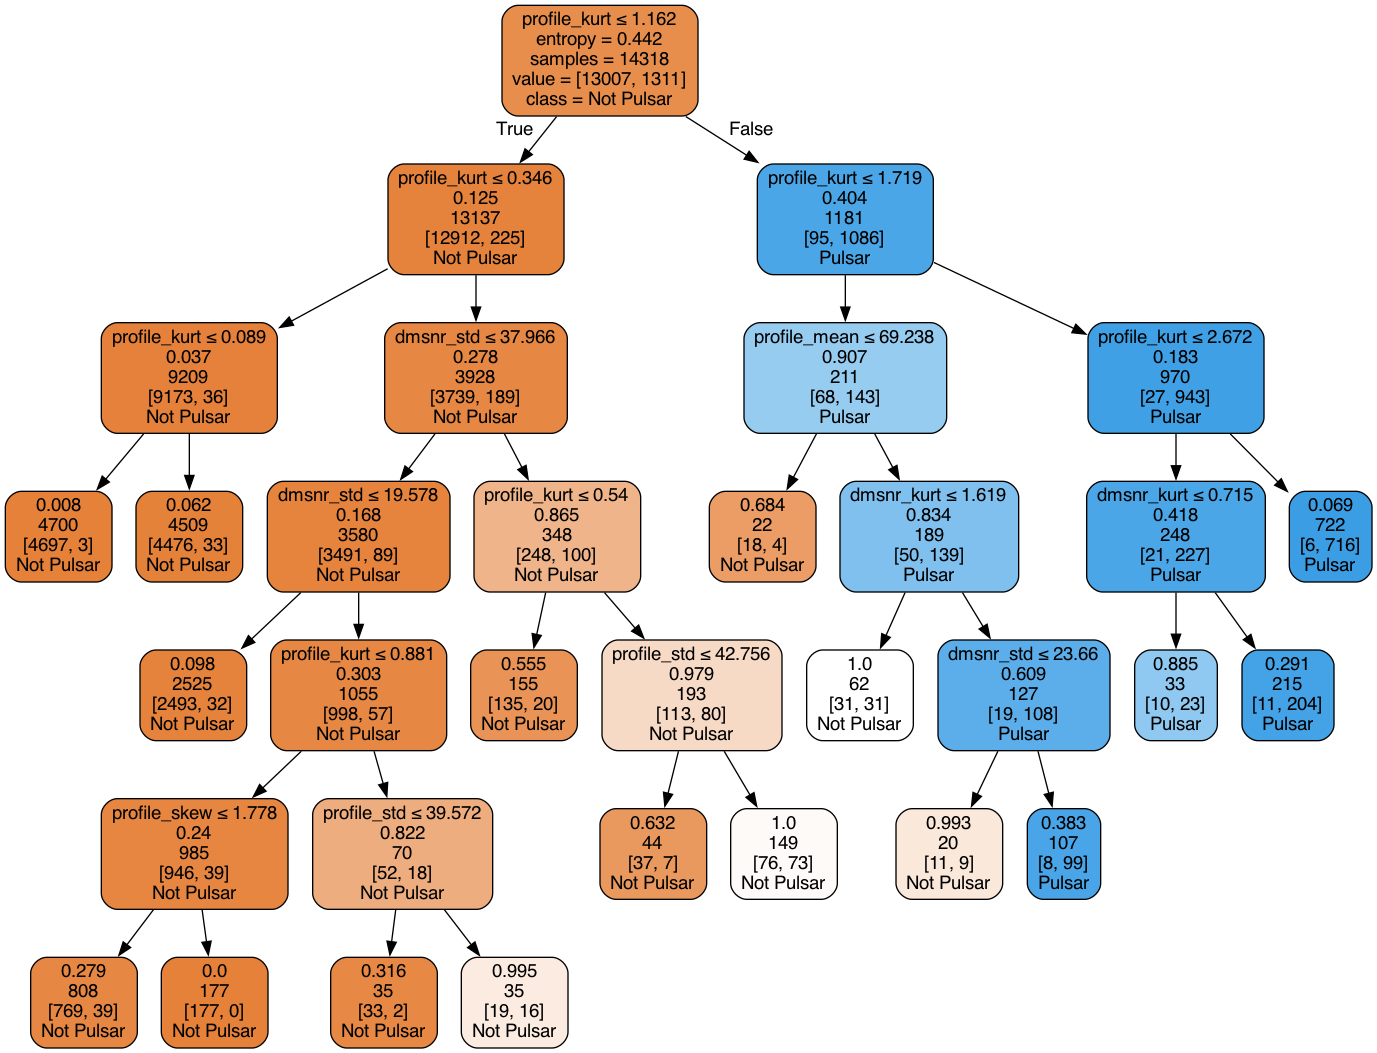

In [37]:
dmba.plotDecisionTree(gscv_dt_lift.best_estimator_,
                      feature_names = X_train.columns,
                      class_names = ['Not Pulsar', 'Pulsar'],
                      impurity = True)

This tree is much more compact and we still end up with several fairly pure terminal leaves (the darker the color the more pure the leaf).

This gives us an idea of what features are actually important, but we can investigate that too.

In [38]:
pd.DataFrame({'Importance':gscv_dt_lift.best_estimator_.feature_importances_,
              'Feature':X_train.columns}).sort_values('Importance',ascending=False)

Importance       Feature
2    0.934213  profile_kurt
5    0.048771     dmsnr_std
6    0.006098    dmsnr_kurt
1    0.004820   profile_std
0    0.003793  profile_mean
3    0.002305  profile_skew
4    0.000000    dmsnr_mean
7    0.000000    dmsnr_skew

The excess kurtosis in the integrated profile is, by far, the most important feature, with the standard deviation of the dispersion measure signal-to-noise ratio coming in second.

What if even 358 targets is actually more than we have resources for?  What if we only had resources to reobserve 5% of the sources in the test partition?  For all of our models, we have more sources than that classified as psr = 1.  The easiest thing to do is, again, rank by predicted probability...would all of them end up with pure samples of 179 pulsars?

In [39]:
#luckily, we already have all of the predictions ranked by probability
print(f'The top 5% of the predicted psr = 1 sources, ranked by probability, for the fully-grown \
decision tree model has {pred_full_df.actual.iloc[:179].sum()} actual pulsars.')

print(f'The top 5% of the predicted psr = 1 sources, ranked by probability, for the accuracy-optimized \
decision tree model has {pred_cv_acc_df.actual.iloc[:179].sum()} actual pulsars.')

print(f'The top 5% of the predicted psr = 1 sources, ranked by probability, for the balanced-accuracy-optimized \
decision tree model has {pred_cv_bacc_df.actual.iloc[:179].sum()} actual pulsars.')

print(f'The top 5% of the predicted psr = 1 sources, ranked by probability, for the lift-optimized \
decision tree model has {pred_cv_lift_df.actual.iloc[:179].sum()} actual pulsars.')

The top 5% of the predicted psr = 1 sources, ranked by probability, for the fully-grown decision tree model has 154 actual pulsars.
The top 5% of the predicted psr = 1 sources, ranked by probability, for the accuracy-optimized decision tree model has 175 actual pulsars.
The top 5% of the predicted psr = 1 sources, ranked by probability, for the balanced-accuracy-optimized decision tree model has 176 actual pulsars.
The top 5% of the predicted psr = 1 sources, ranked by probability, for the lift-optimized decision tree model has 178 actual pulsars.


It's no surpise that the fully-grown tree performs the worst.  The other three models all do well, though the lift-optimized model does perform the best, having a near pure top 5% with only one non-pulsar sneaking in.

While the lift-optimized model does perform best, the difference isn't striking because we are able to do fairly well on our rare class.  What if we remove the profile information from our features, imagining that a new post-doc forgot to include those measurements when they sent us the data and we have a proposal deadline in two days so there is no time to retrieve that info.  It is possible that the DM info might be enough, with a particular signal expected...

In [40]:
profile_columns = [col for col in X_train.columns if col.startswith('profile')]
X_train_dm = X_train.drop(columns = profile_columns)
X_test_dm = X_test.drop(columns = profile_columns)

We'll train a model optimized for accuracy and the one optimized for lift.  First, we need to train the fully grown tree, but we won't spend a lot of time looking at it's performance.

In [41]:
full_dt_dm_clf = DecisionTreeClassifier(criterion = 'entropy')

#now let's train, letting the tree grow fully
full_dt_dm_clf.fit(X_train_dm, y_train)

DecisionTreeClassifier(criterion='entropy')

In [42]:
prune_alphas_dm = full_dt_dm_clf.cost_complexity_pruning_path(X_train_dm, y_train)['ccp_alphas']

print(f'This leaves us with a grid of {len(prune_alphas_dm)} values to check.')
print(f'Doing a quick sanity check, the minimum value is {min(prune_alphas_dm):.2e}.')

This leaves us with a grid of 362 values to check.
Doing a quick sanity check, the minimum value is 0.00e+00.


In [43]:
gscv_dt_dm_accuracy = GridSearchCV(DecisionTreeClassifier(criterion = 'entropy'),
                       [{'ccp_alpha': prune_alphas_dm}],
                       cv = 5,
                       n_jobs = 5,
                       scoring = 'accuracy',
                       return_train_score = True)

gscv_dt_dm_accuracy.fit(X_train_dm, y_train)

print('The best parameter is:',gscv_dt_dm_accuracy.best_params_)
print(f'With best overall accuracy of {gscv_dt_dm_accuracy.best_score_:.2%}')

The best parameter is: {'ccp_alpha': 0.000849568260944585}
With best overall accuracy of 94.91%


In [44]:
y_pred_test_dm_acc = gscv_dt_dm_accuracy.best_estimator_.predict(X_test_dm)
print(classification_report(y_test, y_pred_test_dm_acc))
dmba.classificationSummary(y_test, y_pred_test_dm_acc, ['Not Pulsar', 'Pulsar'])

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3252
           1       0.80      0.59      0.68       328

    accuracy                           0.95      3580
   macro avg       0.88      0.79      0.83      3580
weighted avg       0.95      0.95      0.95      3580

Confusion Matrix (Accuracy 0.9489)

           Prediction
    Actual Not Pulsar     Pulsar
Not Pulsar       3204         48
    Pulsar        135        193


We were able to correctly classify some actual pulsars, with an overall accuracy of 94.5% we're still doing 'ok', except that we only have 58.8% accuracy on our psr = 1 class.  If we still had to select 10% to reobserve, we now have to pick an additional 117 sources, and if do so at random we can expect to maybe pick up only 5 pulsars (a few more if we're lucky, even 0 if we're unlucky).

What does the lift chart look like for this model?

In [45]:
pred_cv_dm_acc_df = pd.DataFrame({'actual': y_test.to_numpy(),
                             'prediction': gscv_dt_dm_accuracy.best_estimator_.predict_proba(X_test_dm)[:,1]})\
                                .sort_values(by = 'prediction', ascending = False)

with plt.style.context('cyberpunk'):
    fig, ax = plt.subplots()
    fig.set_size_inches(h = 6, w = 9)
    
    ax = dmba.liftChart(pred_cv_dm_acc_df.actual, ax = ax)
    ax.set_title('Decile Lift Chart - DM only, Optimze for Accuracy')

    mplcyberpunk.add_bar_gradient(ax.patches)

    fig.savefig('DecileLift_DMOnly_OptAccuracy.png')

In [46]:
print(f'If we took the top decile, we would have {sum(pred_cv_dm_acc_df.actual.iloc[:358])} pulsars in our sample.')

If we took the top decile, we would have 221 pulsars in our sample.


Ranking still nets us 23 more pulsars than randomly selecting from the rest of the sources, on top of the correctly classified 193 pulsars.  Now let's try and optimize for lift. 

In [47]:
gscv_dt_dm_lift = GridSearchCV(DecisionTreeClassifier(criterion = 'entropy'),
                       [{'ccp_alpha': prune_alphas_dm}],
                       cv = 5,
                       n_jobs = 5,
                       scoring = lift_scorer,
                       return_train_score = True)

gscv_dt_dm_lift.fit(X_train_dm, y_train)

print('The best parameter is:',gscv_dt_dm_lift.best_params_)
print(f'With best overall lift in the top decile of {gscv_dt_dm_lift.best_score_:.2f}')

The best parameter is: {'ccp_alpha': 0.0005665276786369971}
With best overall lift in the top decile of 7.00


In [48]:
y_pred_test_dm_lift = gscv_dt_dm_lift.best_estimator_.predict(X_test_dm)
print(classification_report(y_test, y_pred_test_dm_lift))
dmba.classificationSummary(y_test, y_pred_test_dm_lift, ['Not Pulsar', 'Pulsar'])

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3252
           1       0.81      0.56      0.67       328

    accuracy                           0.95      3580
   macro avg       0.88      0.78      0.82      3580
weighted avg       0.94      0.95      0.94      3580

Confusion Matrix (Accuracy 0.9480)

           Prediction
    Actual Not Pulsar     Pulsar
Not Pulsar       3209         43
    Pulsar        143        185


As expected, the performance is a little bit worse, but we're not really concerned with those metrics above.  Let's look at the lift chart and ranking results.

In [49]:
pred_cv_dm_lift_df = pd.DataFrame({'actual': y_test.to_numpy(),
                             'prediction': gscv_dt_dm_lift.best_estimator_.predict_proba(X_test_dm)[:,1]})\
                                .sort_values(by = 'prediction', ascending = False)

with plt.style.context('cyberpunk'):
    fig, ax = plt.subplots()
    fig.set_size_inches(h = 6, w = 9)
    
    ax = dmba.liftChart(pred_cv_dm_lift_df.actual, ax = ax)
    ax.set_title('Decile Lift Chart - DM only, Optimze for Lift')

    mplcyberpunk.add_bar_gradient(ax.patches)

    fig.savefig('DecileLift_DMOnly_OptLift.png')

In [50]:
print(f'If we took the top decile, we would have {sum(pred_cv_dm_lift_df.actual.iloc[:358])} pulsars in our sample.')

If we took the top decile, we would have 231 pulsars in our sample.


The chart and performance doesn't look as nice as it did before, using the profile features, but optimizing for lift does net us 7 more pulsars in our top 10%.

What about our hypothetical where we actually could only observe 5%?

In [51]:
print(f'The top 5% of the predicted psr = 1 sources, ranked by probability, for the DM-only accuracy-optimized \
decision tree model has {pred_cv_dm_acc_df.actual.iloc[:179].sum()} actual pulsars.')

print(f'The top 5% of the predicted psr = 1 sources, ranked by probability, for the DM-only lift-optimized \
decision tree model has {pred_cv_dm_lift_df.actual.iloc[:179].sum()} actual pulsars.')

The top 5% of the predicted psr = 1 sources, ranked by probability, for the DM-only accuracy-optimized decision tree model has 148 actual pulsars.
The top 5% of the predicted psr = 1 sources, ranked by probability, for the DM-only lift-optimized decision tree model has 156 actual pulsars.


Here, the difference is a bit more pronounced, with the lift-optimized model picking up 8 extra sources.  Improving our observing efficiency in this hypothetical scenario from 82.7% to 87.2% (a 5.4% increase).